In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline


def my_drop_na_columns(X,NANthreshold):

    df = X
    colcount = df.shape[1]
    #Get count of NA in each column
    series_cols = df.isnull().sum(axis = 0).sort_values(ascending=False)

    #filter the list to include only those with counts above threshold
    series_cols_remove = series_cols[series_cols.values >= NANthreshold]
    series_cols_keep = series_cols[(series_cols.values < NANthreshold) & (series_cols.values > 0) ]
    
    #put the to-remove column names in a list
    list_colstodrop = series_cols_remove.index.tolist()

    #drop the columns
    df = df.drop(labels = list_colstodrop, axis=1)

    #print the results
    print('Dropped {} of {} Columns - containing more than {} NANs\n'.format(
          series_cols_remove.shape[0],colcount,NANthreshold))
    print(series_cols_remove)
    
    print('\n{} Columns remain with NANs\n'.format(series_cols_keep.shape[0]))
    print(series_cols_keep)
    print('\nShape before: ' + str(X.shape))
    print('Shape after: ' + str(df.shape))
    print('\n')    


In [2]:
raw_data = pd.read_csv('boston_marathon_results.csv')
raw_data.shape

(16164, 21)

In [3]:
raw_data.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [4]:
df = raw_data.copy()

#---------Clean Data----------- 

#Handle nulls
print('Remove ctz column because it is mostly null')
df.drop(columns=['ctz'], axis=1, inplace=True)

print('Remove name,city,state, division, genderdivision columns')
df.drop(columns=['name','city','state','division','genderdiv'], axis=1, inplace=True)

print('remove the remaining rows containing nulls.  1500 w null states') 
df.dropna(inplace=True)

#print('Change - to 0')
df.replace('-', value='0', inplace=True)

print('Remove the W and F character in bib')
df = df[df.bib.str.contains('W') == False]
df = df[df.bib.str.contains('F') == False]
#df['bib'] = df['bib'].str.replace('W','')
#df['bib'] = df['bib'].str.replace('F','')

df['country'] = np.where(df.country.isin(['USA','CAN']) == False, 'OTHER', df.country)
print('create dummies for country and gender')
dummies = pd.get_dummies(df.country)
df = pd.concat([df, dummies], axis=1)
df['male'] = np.where(df.gender == 'M', 1, 0)
df.drop(columns=['country','gender','bib'], axis=1, inplace=True)

#Change races to 0 or 1
#race_types = ['5k','10k','20k','25k','30k','35k','40k','half']
#for col in race_types:
#    df[col] = np.where(df[col] == '-', 0, 1)

#Change string columns to numeric
print('Casting columns as numeric')
object_cols = df.select_dtypes(include=[np.object]).columns   
for col in object_cols:
    print('  Changing {} column to numeric'.format(col))
    df[col] = pd.to_numeric(df[col])

#Normalize data
#df_norm = pd.DataFrame(normalize(df), columns=df.columns)

df.shape

Remove ctz column because it is mostly null
Remove name,city,state, division, genderdivision columns
remove the remaining rows containing nulls.  1500 w null states
Remove the W and F character in bib
create dummies for country and gender
Casting columns as numeric
  Changing 25k column to numeric
  Changing 10k column to numeric
  Changing half column to numeric
  Changing 30k column to numeric
  Changing 5k column to numeric
  Changing 20k column to numeric
  Changing 35k column to numeric
  Changing 40k column to numeric


(16111, 16)

In [5]:
df.head()

,25k,age,10k,half,official,overall,pace,30k,5k,20k,35k,40k,CAN,OTHER,USA,male
1,77.27,30,30.90,64.90,132.50,5,5.07,92.97,15.90,61.52,108.78,124.77,0,1,0,1
2,77.23,23,30.90,64.92,130.37,1,4.98,92.72,15.93,61.53,108.68,123.78,0,1,0,1
5,77.25,28,30.88,64.92,130.47,3,4.98,92.72,15.93,61.53,108.70,123.78,0,1,0,1
7,77.23,28,30.88,64.90,132.73,6,5.07,92.93,15.90,61.52,109.07,125.20,0,1,0,1
9,77.25,32,30.90,64.92,141.67,27,5.42,92.77,15.93,61.53,111.13,131.98,0,1,0,1


In [6]:
X = df[['age','official','CAN','OTHER','USA','male']]
X.head()

,age,official,CAN,OTHER,USA,male
1,30,132.50,0,1,0,1
2,23,130.37,0,1,0,1
5,28,130.47,0,1,0,1
7,28,132.73,0,1,0,1
9,32,141.67,0,1,0,1


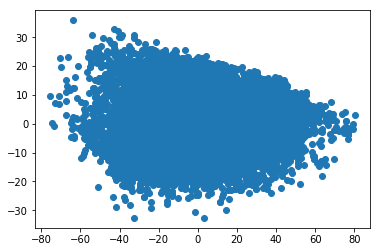

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1])

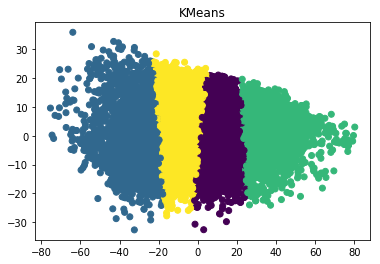

In [8]:
#----------------------------------------------
#-------------- K Means -----------------------
#----------------------------------------------
labels = KMeans(n_clusters=4, random_state=42).fit_predict(X_pca)
plt.title('KMeans')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


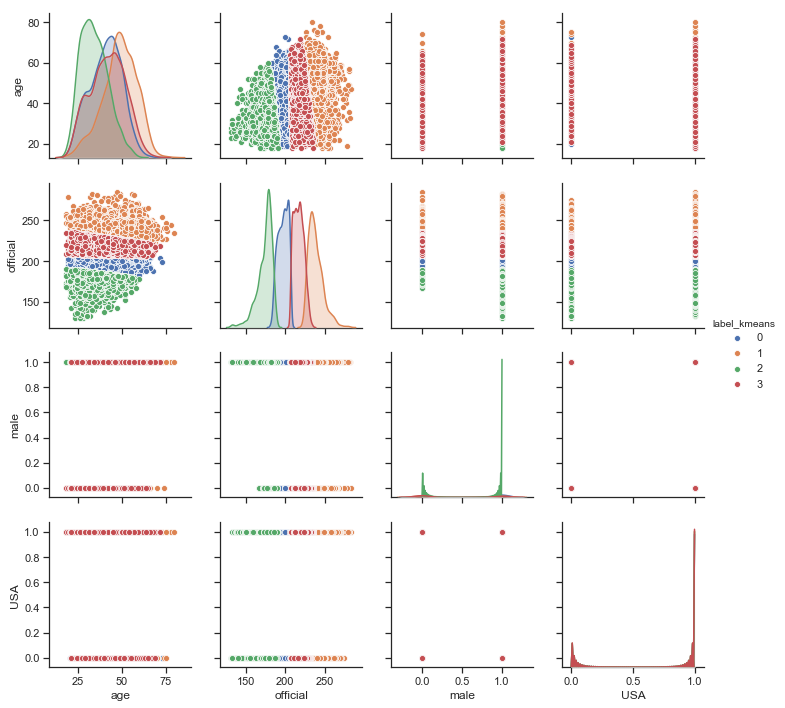

In [9]:
#apply labels back into feature set
X['label_kmeans'] = labels
sns.set(style="ticks")
sns.pairplot(X, hue="label_kmeans", kind='scatter', vars=['age','official','male','USA'])

In [10]:
#----------------------------------------------
#-------------- Mean Shift -----------------------
#----------------------------------------------
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
#bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=9, bin_seeding=True)
ms.fit(X)

# Extract cluster assignments for each data point.
labels = ms.labels_
#this does same thing:  labels = ms.predict(X_train)   

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 6


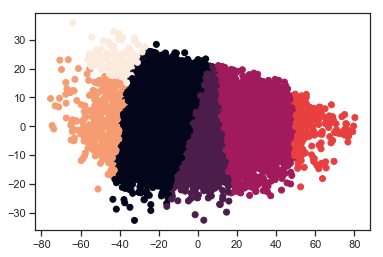

In [11]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/nonparamet

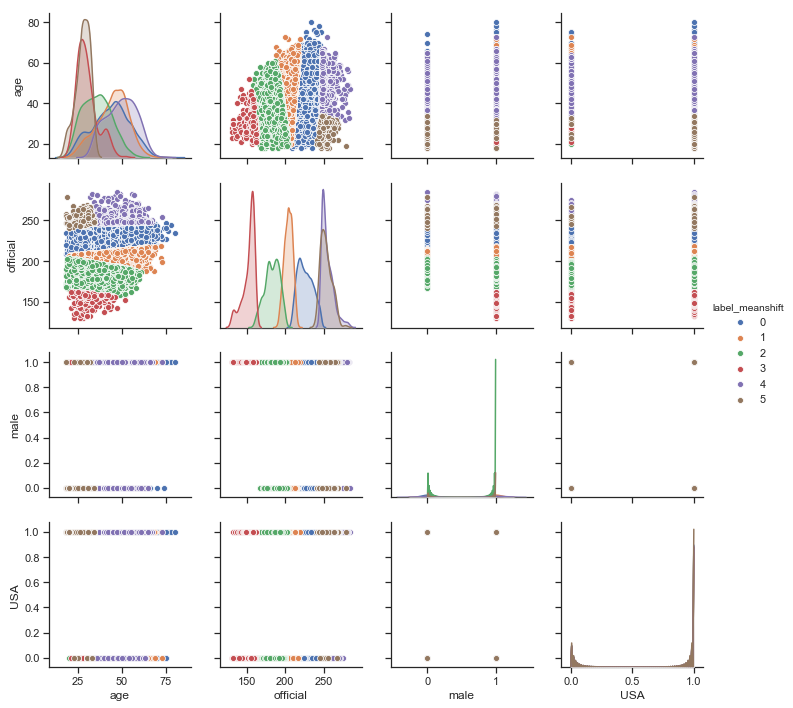

In [12]:
#apply labels back into feature set
X['label_meanshift'] = labels
sns.set(style="ticks")
sns.pairplot(X, hue="label_meanshift", kind='scatter', vars=['age','official','male','USA'])

In [17]:
X_normalize = normalize(X)
X_sample = X.sample(n=2000)
X_sample_normalize = normalize(X_sample)
#X_sample_pca = pca.fit_transform(X_sample)
print('X_Normalize shape: ' + str(X_normalize.shape))
print('X_sample_normalize shape: ' + str(X_sample_normalize.shape))

X_Normalize shape: (16111, 8)
X_sample_normalize shape: (2000, 8)


In [18]:
#----------------------------------------------
#-------------- Spectral Clustering -----------------------
#----------------------------------------------

from sklearn.cluster import SpectralClustering

n_clusters=4

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters, n_neighbors=5)
sc.fit(X_normalize)

#Predicted clusters.
labels=sc.fit_predict(X_normalize)

labels.shape
#Graph results.
#plt.scatter(X_sample[:, 0], X_sample[:, 1], c=labels)
#plt.show()

(16111,)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


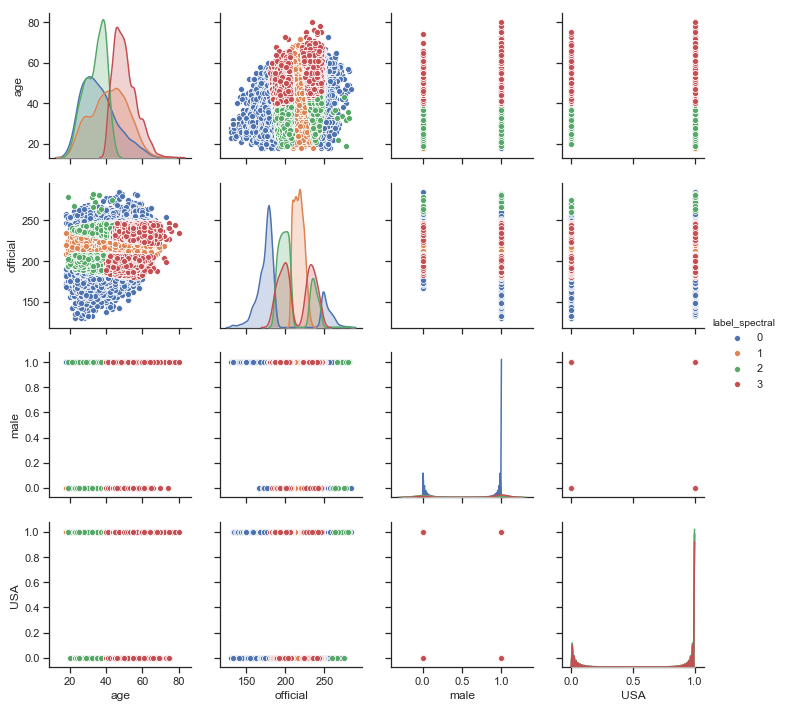

In [19]:
#apply labels back into feature set
X['label_spectral'] = labels
sns.set(style="ticks")
sns.pairplot(X, hue="label_spectral", kind='scatter', vars=['age','official','male','USA'])

In [26]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation(damping=.97, convergence_iter=7).fit(X_sample_normalize)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))


Done
Estimated number of clusters: 39


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


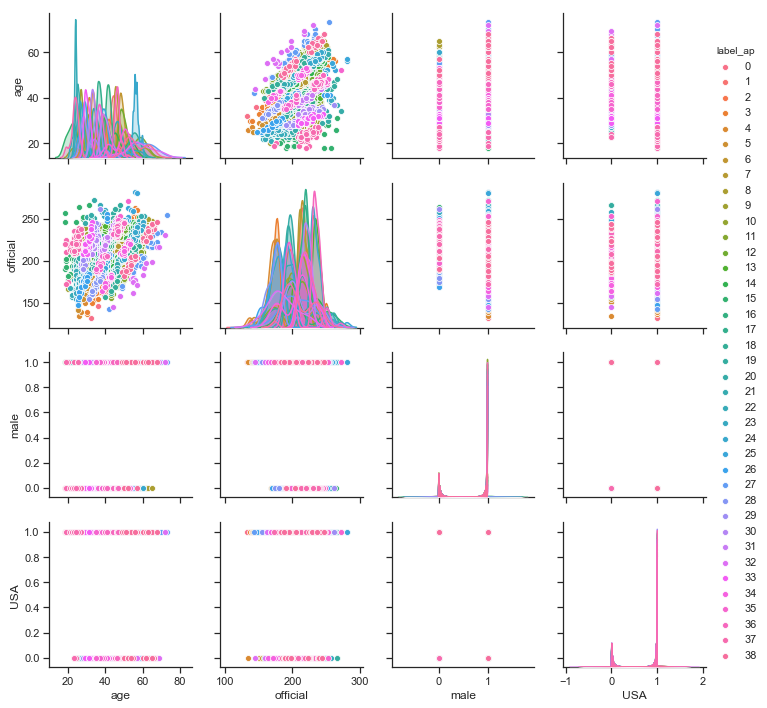

In [27]:
X_sample_df = pd.DataFrame(X_sample, columns=X.columns)
X_sample_df['label_ap'] = labels
sns.set(style="ticks")
sns.pairplot(X_sample_df, hue="label_ap", kind='scatter', 
             vars=['age','official','male','USA'])

In [45]:
X

,age,official,CAN,OTHER,USA,male,label_kmeans,label_meanshift,label_spectral
1,30,132.50,0,1,0,1,2,3,0
2,23,130.37,0,1,0,1,2,3,0
5,28,130.47,0,1,0,1,2,3,0
7,28,132.73,0,1,0,1,2,3,0
9,32,141.67,0,1,0,1,2,3,0
10,23,135.70,0,1,0,1,2,3,0
14,26,134.13,0,1,0,1,2,3,0
21,30,134.47,0,1,0,1,2,3,0
23,32,132.20,0,0,1,1,2,3,0
25,30,138.38,0,0,1,1,2,3,0


In [57]:

zero_data = np.zeros(shape=(len(X),len(X.columns)))
y = pd.DataFrame(zero_data, columns=X.columns)

#Split data into folds
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits=4, test_size=.01)
skf.get_n_splits(X, y)

i=1
print('\n--- Results KMeans---------')
for train_index, test_index in skf.split(X, y):
    sample = X.iloc[train_index]
    labels = sample.loc[:,'label_kmeans']
    features = sample.iloc[:,0:5]
    score = metrics.silhouette_score(features, labels, metric='euclidean')
    print('Sample #' + str(i) + ' silhouette score: ' + str(score))
    i = i + 1

i=1
print('\n--- Results MeanShift---------')
for train_index, test_index in skf.split(X, y):
    sample = X.iloc[train_index]
    labels = sample.loc[:,'label_meanshift']
    features = sample.iloc[:,0:5]
    score = metrics.silhouette_score(features, labels, metric='euclidean')
    print('Sample #' + str(i) + ' silhouette score: ' + str(score))
    i = i + 1
    
i=1
print('\n--- Results Spectral Clustering---------')
for train_index, test_index in skf.split(X, y):
    sample = X.iloc[train_index]
    labels = sample.loc[:,'label_spectral']
    features = sample.iloc[:,0:5]
    score = metrics.silhouette_score(features, labels, metric='euclidean')
    print('Sample #' + str(i) + ' silhouette score: ' + str(score))
    i = i + 1
    

zero_data = np.zeros(shape=(len(X_sample_df),len(X_sample_df.columns)))
y = pd.DataFrame(zero_data, columns=X_sample_df.columns)

#Split data into folds
skf = StratifiedShuffleSplit(n_splits=3, test_size=.01)
skf.get_n_splits(X_sample_df, y)

i=1
print('\n--- Results Affinity Propogation---------')
for train_index, test_index in skf.split(X_sample_df, y):
    sample = X_sample_df.iloc[train_index]
    labels = sample.loc[:,'label_ap']
    features = sample.iloc[:,0:5]
    score = metrics.silhouette_score(features, labels, metric='euclidean')
    print('Sample #' + str(i) + ' silhouette score: ' + str(score))
    i = i + 1


--- Results KMeans---------
Sample #1 silhouette score: 0.33545823058309
Sample #2 silhouette score: 0.3349987079213082
Sample #3 silhouette score: 0.33517891047086074
Sample #4 silhouette score: 0.335415471113847

--- Results MeanShift---------
Sample #1 silhouette score: 0.2446917394818657
Sample #2 silhouette score: 0.24480555259697653
Sample #3 silhouette score: 0.24479513452306612
Sample #4 silhouette score: 0.24476943732115142

--- Results Spectral Clustering---------
Sample #1 silhouette score: 0.1135896386305798
Sample #2 silhouette score: 0.11321378024914742
Sample #3 silhouette score: 0.11374848591948425
Sample #4 silhouette score: 0.11295622452217456

--- Results Affinity Propogation---------
Sample #1 silhouette score: -0.17796225370116875
Sample #2 silhouette score: -0.1759802628770329
Sample #3 silhouette score: -0.17905742439531888


In [ ]:
# from sklearn import metrics
# from sklearn.metrics import pairwise_distances

# for sample in [X1, X2, X3, X4]:
#     model = KMeans(n_clusters=2, random_state=42).fit(sample)
#     labels = model.labels_
#     print(metrics.silhouette_score(sample, labels, metric='euclidean'))


In [ ]:
# from itertools import cycle

# plt.figure(1)
# plt.clf()

# # Cycle through each cluster and graph them with a center point for the
# # exemplar and lines from the exemplar to each data point in the cluster.
# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     class_members = labels == k
#     cluster_center = X_sample[cluster_centers_indices[k]]
#     plt.plot(X_sample[class_members, 0], X_sample[class_members, 1], col + '.')
#     plt.plot(cluster_center[0],
#              cluster_center[1],
#              'o',
#              markerfacecolor=col,
#              markeredgecolor='k')
#     for x in X_sample[class_members]:
#         plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

# plt.title('Estimated number of clusters: {}'.format(n_clusters_))
# plt.show()

# DRILL: Mo' blobs, mo' problems?

You've seen how these three methods work on three blobs of reasonably separated data. Now go back and change the data. Create more or fewer blobs, and set the blobs closer together or farther apart. Set up at least three different blob configuations, then run the four methods ($k$-means, mean shift, spectral clustering and affinity propagation) on each one.  Write up a report for your mentor where you discuss what you learned about the clustering methods based on their relative performance for your different blob setups. 